In [127]:
from feature_engine.imputation import MeanMedianImputer
import pickle
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import KFold
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, precision_score, recall_score, accuracy_score
from sklearn.preprocessing import label_binarize
from sklearn.utils.class_weight import compute_class_weight

from tqdm import tqdm_notebook
import warnings
from sklearn.exceptions import ConvergenceWarning
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

warnings.simplefilter('ignore')
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=ConvergenceWarning)

seed = 42
np.random.seed(seed)

In [128]:
def plot_roc_curve(model, X, Y):
    """
    Функция для построения ROC кривой и вывода метрики AUC.

    Параметры:
    model: обученная модель, которая поддерживает метод predict_proba
    X (numpy.ndarray): Набор данных для предсказания, shape (n_samples, n_features)
    Y (numpy.ndarray): Истинные ответы, shape (n_samples,)
    """
    # Получение предсказанных вероятностей для положительного класса (1)
    y_proba = model.predict_proba(X)[:, 1]

    # Вычисляем ROC кривую и AUC
    fpr, tpr, thresholds = roc_curve(Y, y_proba)
    roc_auc = roc_auc_score(Y, y_proba)

    # Строим график
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Линия для случайного угадывания
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

In [129]:
def reduce_mem_usage(df: pd.DataFrame) -> pd.DataFrame:
    """ Проходит по всем столбцам DataFrame и изменяет тип данных
        для уменьшения использования памяти.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype.name

        if col_type not in ['object', 'category', 'datetime64[ns, UTC]']:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [130]:
def evaluate_models(models, model_names, X, Y) -> pd.DataFrame:
    """
    Функция для оценки списка моделей по метрикам точности, F1, полноты, точности, ROC AUC и Gini.
    
    Параметры:
    models (list): Список обученных моделей
    model_names (list): Список названий моделей
    X (numpy.ndarray): Набор данных для предсказания, shape (n_samples, n_features)
    Y (numpy.ndarray): Истинные ответы, shape (n_samples,)
    
    Возвращает:
    pandas.DataFrame: Таблица с метриками для каждой модели
    """
    if len(models) != len(model_names):
        raise ValueError("Списки моделей и названий моделей должны быть одинаковой длины")
    
    results = []
    for model, name in zip(models, model_names):
        y_pred = model.predict(X)
        accuracy = accuracy_score(Y, y_pred)
        f1 = f1_score(Y, y_pred)
        recall = recall_score(Y, y_pred)
        precision = precision_score(Y, y_pred)
        
        # Вычисление предсказания вероятностей для метрик ROC AUC и Gini
        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X)[:, 1]
            roc_auc = roc_auc_score(Y, y_proba)
            gini = 2 * roc_auc - 1
        else:
            roc_auc = None
            gini = None
        
        results.append({
            'Model': name,
            'Accuracy': accuracy,
            'F1 Score': f1,
            'Recall': recall,
            'Precision': precision,
            'ROC AUC': roc_auc,
            'Gini': gini
        })
    
    results_df = pd.DataFrame(results)
    return results_df

# Анализ данных и очистка

In [131]:
data = pd.read_csv('train_share.tsv', sep='\t')
data

,graph_1,graph_2,graph_3,feature_1,bki_1,graph_4,feature_2,graph_5,feature_3,graph_6,...,graph_22,application_2,bki_14,bki_15,feature_37,bki_16,bki_17,mb_15,feature_38,target
0,73.0,25.0,63.0,0.0,-3.307791,59.0,36.0,19544.0,0.0,91.0,...,0.0,0,44211.0,31.0,390.414429,0.571132,0.000,12527.0,0.0,0
1,64.0,37.0,68.0,0.0,-2.527839,106.0,36.0,1457.0,0.0,180.0,...,6.0,0,5600.0,3.0,663.702500,1.447663,0.100,10276.0,0.0,0
2,73.0,34.0,80.0,0.0,-2.985949,72.0,44.0,13071.0,0.0,151.0,...,1.0,0,250889.0,8.0,NaN,0.234987,11.240,4588.0,0.0,0
3,170.0,99.0,203.0,0.0,-3.392264,228.0,NaN,7000.0,NaN,388.0,...,2.0,0,NaN,NaN,471.623097,NaN,NaN,22968.0,0.0,0
4,65.0,20.0,77.0,0.0,-2.657559,115.0,18.0,21725.0,0.0,190.0,...,13.0,1,0.0,0.0,411.162400,0.000000,29.402,15687.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1265169,2.0,2.0,1.0,0.0,-2.806880,5.0,NaN,0.0,NaN,7.0,...,1.0,0,NaN,NaN,297.153600,NaN,NaN,2658.0,0.0,0
1265170,15.0,6.0,12.0,0.0,-2.971577,14.0,15.0,0.0,0.0,26.0,...,2.0,0,NaN,NaN,56.500000,NaN,NaN,4694.0,0.0,0
1265171,240.0,135.0,356.0,0.0,-3.313476,401.0,35.0,689921.0,0.0,668.0,...,3.0,0,38000.0,4.0,552.291581,0.114097,25.567,183997.0,205.0,0
1265172,17.0,2.0,6.0,0.0,-3.871151,22.0,NaN,500.0,NaN,40.0,...,4.0,0,NaN,NaN,1475.000000,NaN,NaN,21792.0,0.0,0


In [132]:
data.isnull().sum()

graph_1         1554
graph_2         1554
graph_3         1554
feature_1      21961
bki_1           7826
               ...  
bki_16        448337
bki_17        462407
mb_15          63474
feature_38    306882
target             0
Length: 101, dtype: int64

In [133]:
data_del_par, nan_par = [], []


for i in data.isnull().sum().items():
    if i[-1] > 0:
        print(i)
    if i[-1] > len(data) * 0.64:
        data_del_par.append(i[0])
    if 0 < i[-1] <= len(data) * 0.64:
        nan_par.append(i[0])

data = data.drop(columns=data_del_par)

('graph_1', 1554)
('graph_2', 1554)
('graph_3', 1554)
('feature_1', 21961)
('bki_1', 7826)
('graph_4', 1554)
('feature_2', 237091)
('graph_5', 1554)
('feature_3', 209540)
('graph_6', 1554)
('graph_7', 1554)
('graph_8', 3467)
('graph_9', 1554)
('graph_10', 5908)
('feature_4', 821634)
('graph_11', 1554)
('graph_12', 1554)
('graph_13', 14785)
('bki_2', 448337)
('graph_14', 1554)
('feature_5', 231544)
('mb_1', 63474)
('graph_15', 3505)
('mb_2', 63474)
('graph_16', 1554)
('bki_3', 469819)
('feature_7', 231544)
('mb_3', 63474)
('feature_8', 231544)
('feature_9', 209540)
('graph_17', 1554)
('bki_4', 17924)
('feature_10', 231544)
('feature_11', 231544)
('feature_12', 21961)
('feature_13', 246097)
('feature_14', 21961)
('mb_4', 63474)
('feature_15', 286710)
('mb_5', 63474)
('graph_18', 9620)
('bki_5', 448337)
('feature_16', 231544)
('partner_1', 771062)
('feature_17', 306882)
('feature_18', 246097)
('partner_2', 629267)
('bki_6', 448337)
('partner_3', 1034265)
('feature_19', 306882)
('feature_2

In [134]:
imputer = MeanMedianImputer(imputation_method='median', variables=nan_par)
imputer.fit(data[nan_par])
data[nan_par] = imputer.transform(data[nan_par])

pickle.dump(imputer, open("MeanMedianImputer.pickle", "wb"))

In [135]:
data

,graph_1,graph_2,graph_3,feature_1,bki_1,graph_4,feature_2,graph_5,feature_3,graph_6,...,graph_22,application_2,bki_14,bki_15,feature_37,bki_16,bki_17,mb_15,feature_38,target
0,73.0,25.0,63.0,0.0,-3.307791,59.0,36.0,19544.0,0.0,91.0,...,0.0,0,44211.0,31.0,390.414429,0.571132,0.000,12527.0,0.0,0
1,64.0,37.0,68.0,0.0,-2.527839,106.0,36.0,1457.0,0.0,180.0,...,6.0,0,5600.0,3.0,663.702500,1.447663,0.100,10276.0,0.0,0
2,73.0,34.0,80.0,0.0,-2.985949,72.0,44.0,13071.0,0.0,151.0,...,1.0,0,250889.0,8.0,360.067061,0.234987,11.240,4588.0,0.0,0
3,170.0,99.0,203.0,0.0,-3.392264,228.0,34.0,7000.0,0.0,388.0,...,2.0,0,59695.0,3.0,471.623097,0.184632,9.970,22968.0,0.0,0
4,65.0,20.0,77.0,0.0,-2.657559,115.0,18.0,21725.0,0.0,190.0,...,13.0,1,0.0,0.0,411.162400,0.000000,29.402,15687.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1265169,2.0,2.0,1.0,0.0,-2.806880,5.0,34.0,0.0,0.0,7.0,...,1.0,0,59695.0,3.0,297.153600,0.184632,9.970,2658.0,0.0,0
1265170,15.0,6.0,12.0,0.0,-2.971577,14.0,15.0,0.0,0.0,26.0,...,2.0,0,59695.0,3.0,56.500000,0.184632,9.970,4694.0,0.0,0
1265171,240.0,135.0,356.0,0.0,-3.313476,401.0,35.0,689921.0,0.0,668.0,...,3.0,0,38000.0,4.0,552.291581,0.114097,25.567,183997.0,205.0,0
1265172,17.0,2.0,6.0,0.0,-3.871151,22.0,34.0,500.0,0.0,40.0,...,4.0,0,59695.0,3.0,1475.000000,0.184632,9.970,21792.0,0.0,0


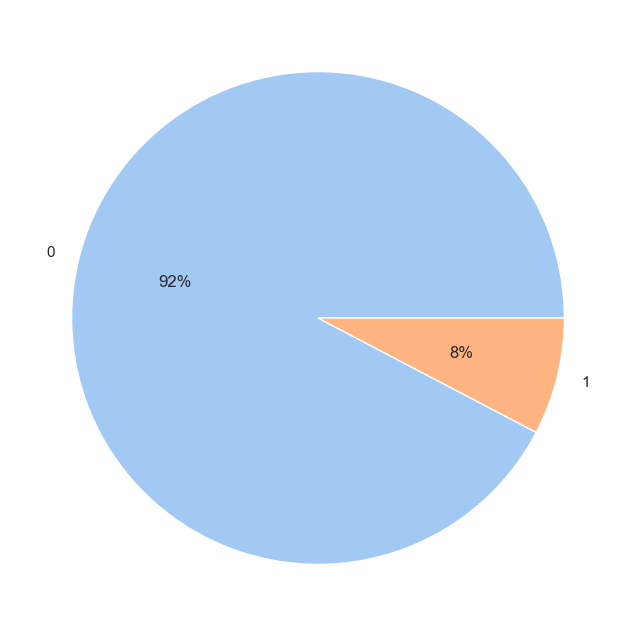

In [136]:
sns.set(rc={'figure.figsize': (15, 8)})
colors = sns.color_palette('pastel')[0:5]
labels = sorted(data['target'].unique())
dt = np.array([len(data[data['target'] == i])for i in labels])
plt.pie(dt, labels=labels, colors = colors, autopct='%.0f%%')
plt.show()

In [137]:
corr_matrix = data.corr()

In [138]:
corr_matrix.corrwith(corr_matrix.target).abs().sort_values()[-64:]

feature_3     0.069985
graph_8       0.071609
feature_37    0.076201
feature_28    0.077065
partner_5     0.078195
                ...   
graph_2       0.421596
graph_12      0.421689
graph_4       0.421705
graph_1       0.425551
target        1.000000
Length: 64, dtype: float64

<Axes: >

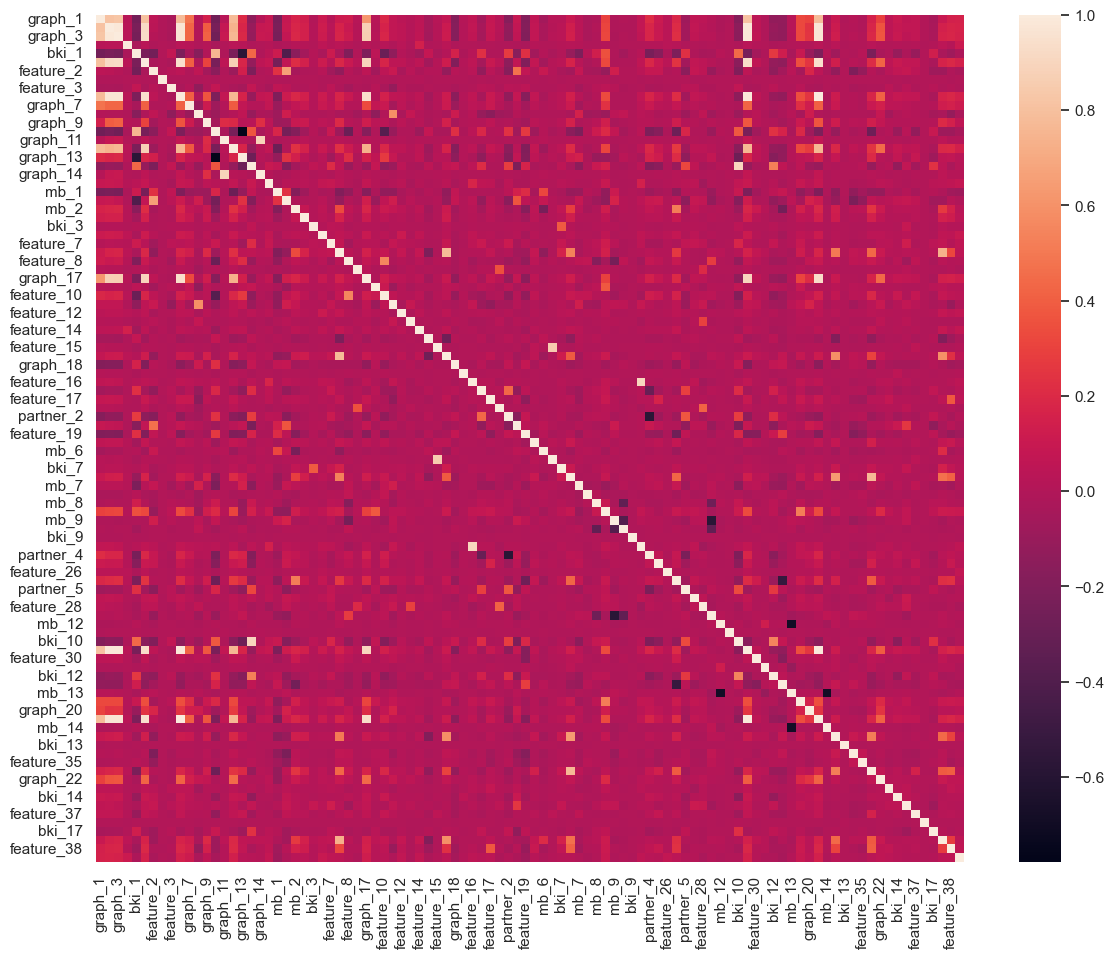

In [139]:
sns.set(rc={'figure.figsize': (14, 11)})

sns.heatmap(corr_matrix, annot=False)

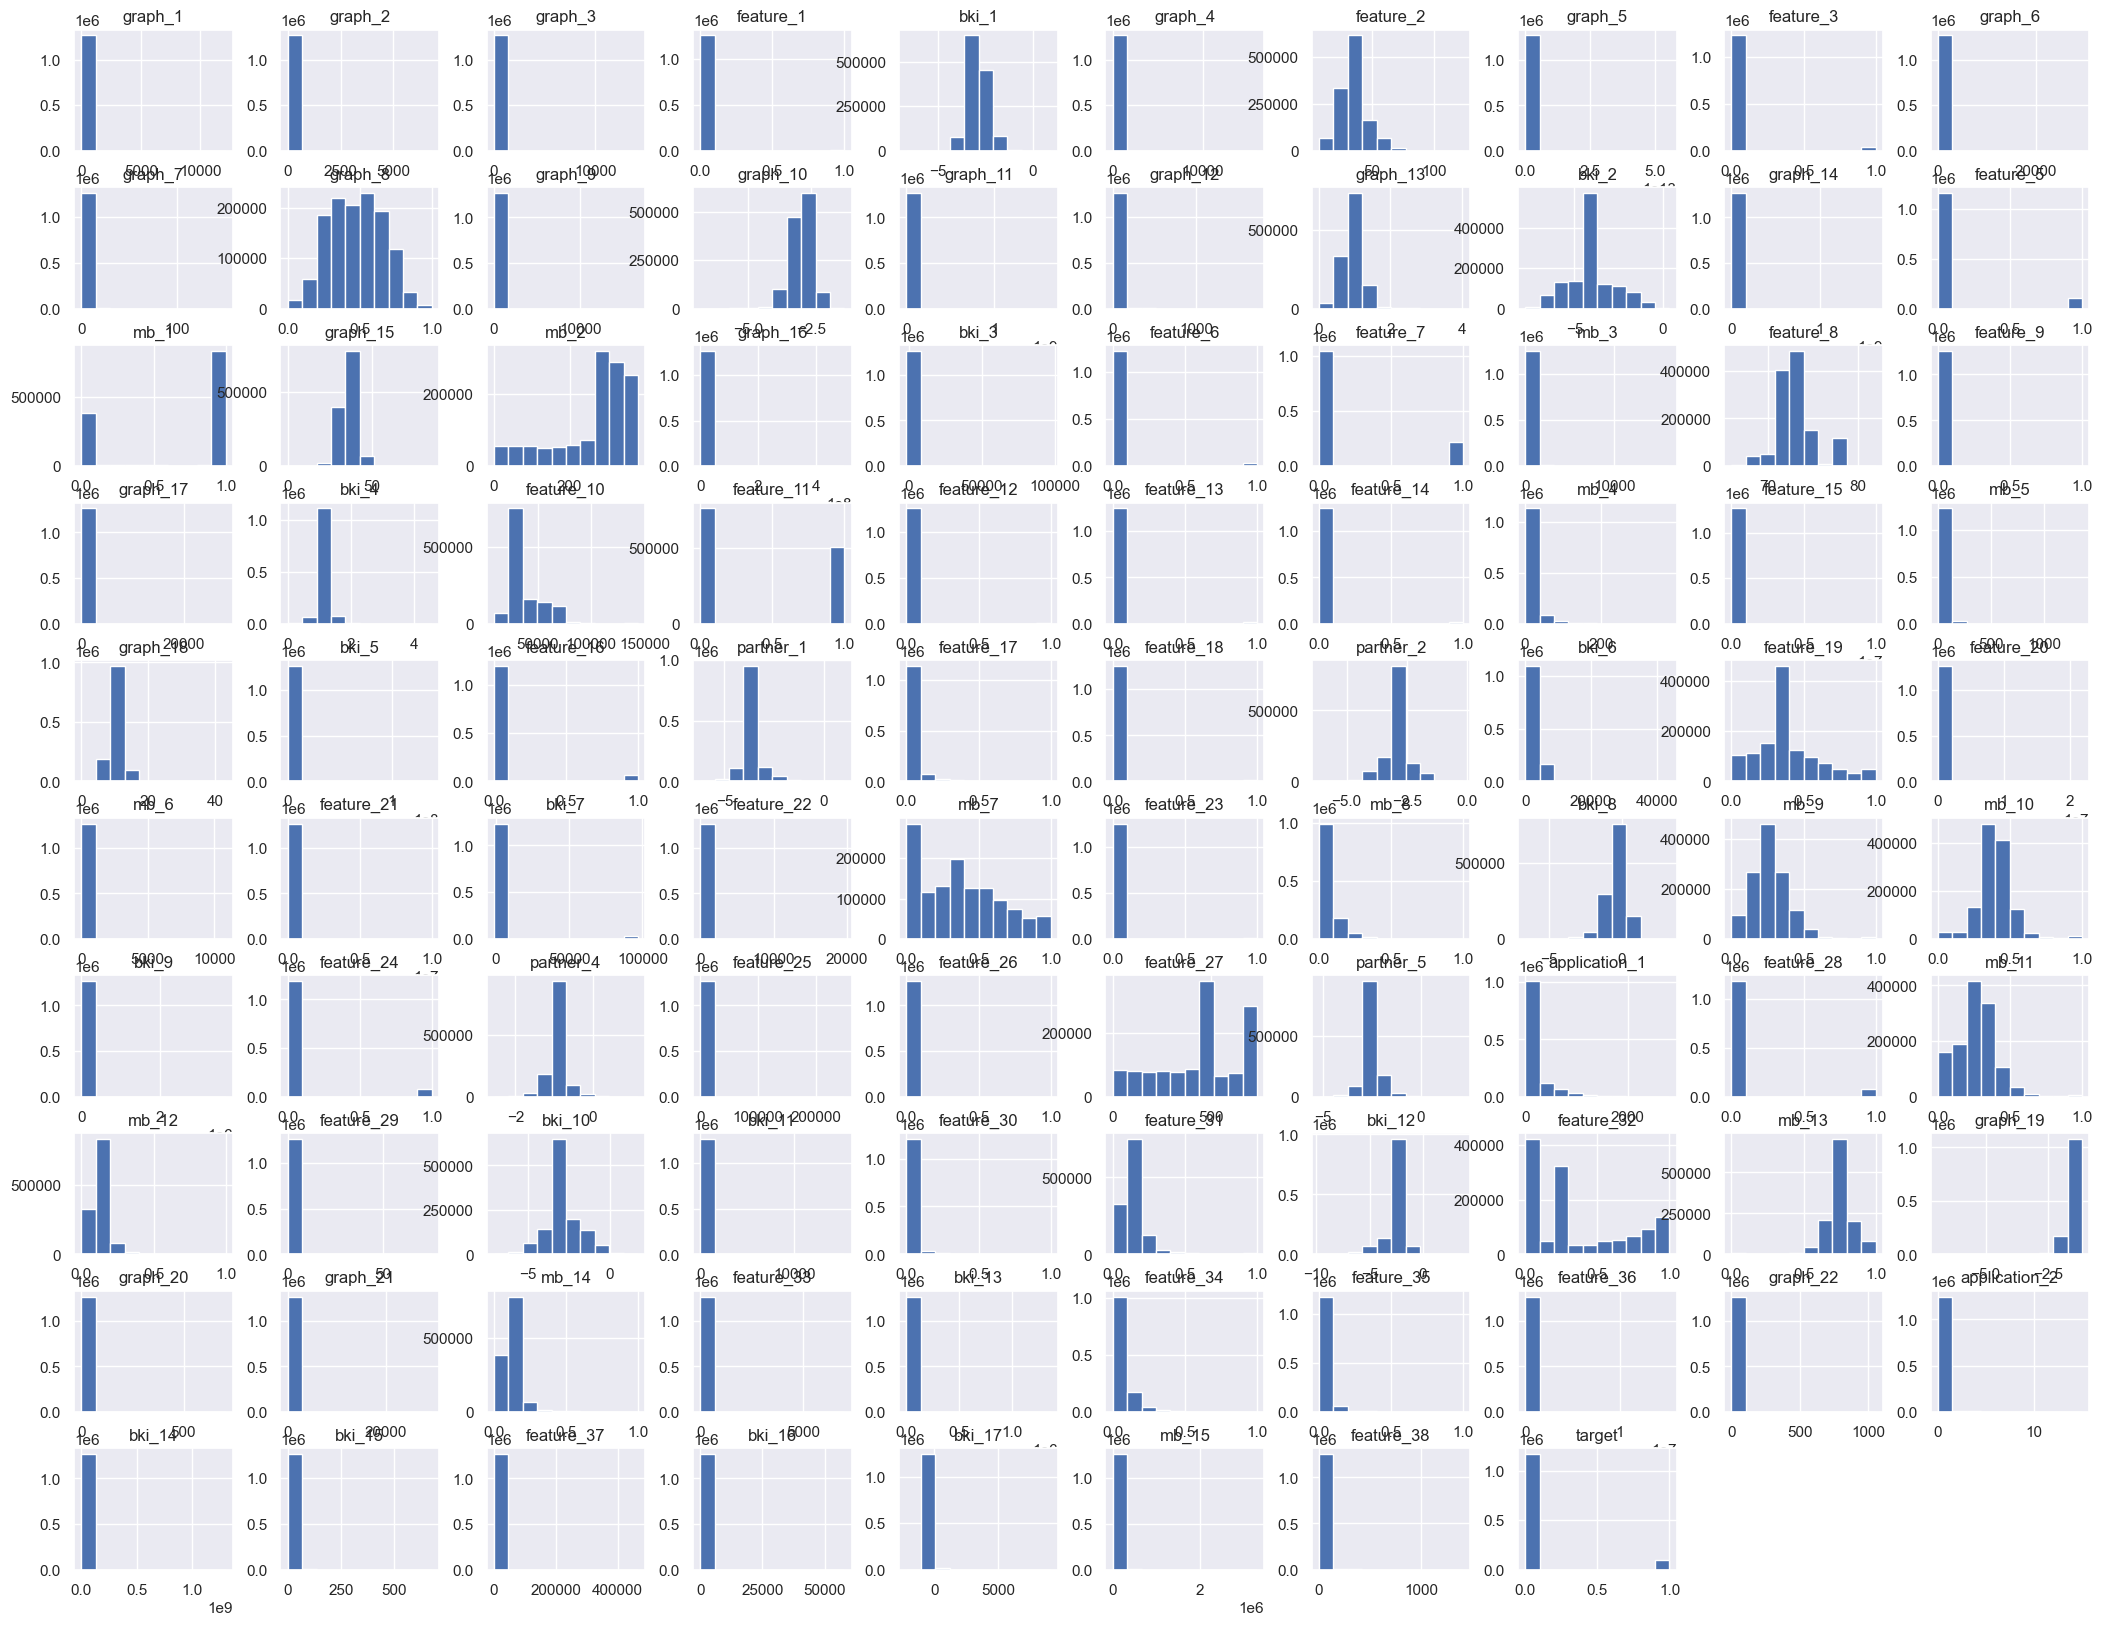

In [140]:
data.hist(figsize=(26, 20));

In [141]:
fss = data.describe()
fss

,graph_1,graph_2,graph_3,feature_1,bki_1,graph_4,feature_2,graph_5,feature_3,graph_6,...,graph_22,application_2,bki_14,bki_15,feature_37,bki_16,bki_17,mb_15,feature_38,target
count,1.265174e+06,1.265174e+06,1.265174e+06,1.265174e+06,1.265174e+06,1.265174e+06,1.265174e+06,1.265174e+06,1.265174e+06,1.265174e+06,...,1.265174e+06,1.265174e+06,1.265174e+06,1.265174e+06,1.265174e+06,1.265174e+06,1.265174e+06,1.265174e+06,1.265174e+06,1.265174e+06
mean,9.281901e+01,4.717524e+01,1.126265e+02,5.335235e-03,-2.904984e+00,1.275653e+02,3.480824e+01,4.398837e+07,2.889907e-02,2.258650e+02,...,3.553955e+00,9.486916e-02,2.393147e+05,4.769141e+00,4.560462e+02,5.471046e-01,1.630256e+01,4.189001e+04,9.444444e+00,7.683607e-02
std,1.187251e+02,6.924903e+01,1.590539e+02,7.284761e-02,5.209499e-01,1.653226e+02,1.058556e+01,4.939155e+10,1.674889e-01,2.975283e+02,...,7.019237e+00,5.190891e-01,1.435534e+06,7.741615e+00,1.032045e+03,6.481097e+01,5.687841e+01,6.307603e+04,3.209443e+01,2.663313e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-6.653944e+00,0.000000e+00,8.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,5.000000e-02,0.000000e+00,-2.190000e+03,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.700000e+01,1.100000e+01,2.900000e+01,0.000000e+00,-3.271146e+00,3.600000e+01,2.800000e+01,0.000000e+00,0.000000e+00,6.600000e+01,...,0.000000e+00,0.000000e+00,2.740900e+04,2.000000e+00,2.764286e+02,1.250000e-01,7.479000e+00,7.068000e+03,0.000000e+00,0.000000e+00
50%,5.700000e+01,2.700000e+01,6.600000e+01,0.000000e+00,-2.950690e+00,7.800000e+01,3.400000e+01,7.750000e+03,0.000000e+00,1.390000e+02,...,2.000000e+00,0.000000e+00,5.969500e+04,3.000000e+00,3.600671e+02,1.846319e-01,9.970000e+00,2.019050e+04,0.000000e+00,0.000000e+00
75%,1.140000e+02,5.800000e+01,1.380000e+02,0.000000e+00,-2.577572e+00,1.580000e+02,4.000000e+01,5.261600e+04,0.000000e+00,2.790000e+02,...,4.000000e+00,0.000000e+00,1.220000e+05,5.000000e+00,4.692161e+02,2.564861e-01,1.310000e+01,5.058500e+04,3.000000e+00,0.000000e+00
max,1.211600e+04,6.817000e+03,1.424400e+04,1.000000e+00,9.459384e-01,1.600500e+04,1.230000e+02,5.555560e+13,1.000000e+00,2.944900e+04,...,1.055000e+03,1.500000e+01,1.300000e+09,6.780000e+02,4.668545e+05,5.800552e+04,9.108000e+03,3.301050e+06,1.409000e+03,1.000000e+00


In [142]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1265174 entries, 0 to 1265173
Data columns (total 98 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   graph_1        1265174 non-null  float64
 1   graph_2        1265174 non-null  float64
 2   graph_3        1265174 non-null  float64
 3   feature_1      1265174 non-null  float64
 4   bki_1          1265174 non-null  float64
 5   graph_4        1265174 non-null  float64
 6   feature_2      1265174 non-null  float64
 7   graph_5        1265174 non-null  float64
 8   feature_3      1265174 non-null  float64
 9   graph_6        1265174 non-null  float64
 10  graph_7        1265174 non-null  float64
 11  graph_8        1265174 non-null  float64
 12  graph_9        1265174 non-null  float64
 13  graph_10       1265174 non-null  float64
 14  graph_11       1265174 non-null  float64
 15  graph_12       1265174 non-null  float64
 16  graph_13       1265174 non-null  float64
 17  bki_2   

In [143]:
for i, j in data.nunique().sort_values().items():
    if j >= 32:
        print(i, j)
    else:
        print(i, j, data[i].unique().tolist())

target 2 [0, 1]
feature_12 2 [0.0, 1.0]
feature_14 2 [0.0, 1.0]
feature_1 2 [0.0, 1.0]
feature_6 2 [0, 1]
feature_23 2 [0.0, 1.0]
feature_26 2 [0.0, 1.0]
feature_11 6 [1.0, 0.0, 0.75, 0.6666666667, 0.4, 0.25]
feature_7 7 [0.0, 1.0, 0.8, 0.75, 0.6666666667, 0.5, 0.2]
feature_9 8 [0.0, 1.0, 0.75, 0.2, 0.5, 0.4, 0.8, 0.6]
feature_18 10 [0.0, 1.0, 0.8, 0.5, 0.75, 0.25, 0.4, 0.2, 0.3333333333, 0.6]
feature_13 10 [0.0, 1.0, 0.75, 0.3333333333, 0.5, 0.2, 0.8, 0.4, 0.25, 0.6]
feature_16 10 [0.0, 1.0, 0.75, 0.5, 0.2, 0.4, 0.25, 0.6666666667, 0.8, 0.6]
feature_5 10 [0.0, 1.0, 0.2, 0.75, 0.25, 0.4, 0.5, 0.6, 0.3333333333, 0.8]
feature_3 11 [0.0, 1.0, 0.75, 0.3333333333, 0.2, 0.5, 0.8, 0.25, 0.6, 0.6666666667, 0.4]
feature_24 11 [0.0, 1.0, 0.2, 0.5, 0.75, 0.25, 0.6, 0.3333333333, 0.4, 0.8, 0.6666666667]
feature_28 11 [0.0, 1.0, 0.4, 0.5, 0.6, 0.75, 0.8, 0.6666666667, 0.3333333333, 0.25, 0.2]
feature_8 15 [70.0, 73.0, 71.0, 72.0, 69.0, 78.0, 75.0, 74.0, 76.0, 66.0, 82.0, 72.4, 70.6, 73.2, 71.75]
ap

In [144]:
data = reduce_mem_usage(data)

Memory usage of dataframe is 945.95 MB
Memory usage after optimization is: 276.30 MB
Decreased by 70.8%


# Обработка теста

In [145]:
test = pd.read_csv('test_share.tsv', sep='\t').drop(columns=['Unnamed: 0'])
test = test.drop(columns=data_del_par)
test[nan_par] = imputer.transform(test[nan_par])
test = reduce_mem_usage(test)
test

Memory usage of dataframe is 223.12 MB
Memory usage after optimization is: 64.69 MB
Decreased by 71.0%


,graph_1,graph_2,graph_3,feature_1,bki_1,graph_4,feature_2,graph_5,feature_3,graph_6,...,feature_36,graph_22,application_2,bki_14,bki_15,feature_37,bki_16,bki_17,mb_15,feature_38
0,23.0,29.0,88.0,0.0,-1.976562,64.0,22.0,136633.453125,0.0,181.0,...,968.630005,4.0,0,0.0,0.0,161.438339,0.969727,30.500000,8504.0,0.0
1,95.0,70.0,147.0,0.0,-3.283203,188.0,34.0,268502.000000,0.0,305.0,...,243878.171875,4.0,0,0.0,0.0,677.439331,0.555664,0.000000,109387.0,0.0
2,92.0,52.0,130.0,0.0,-3.814453,135.0,34.0,205182.000000,0.0,224.0,...,581071.125000,1.0,0,500000.0,3.0,994.984741,0.323975,9.578125,175186.0,23.0
3,31.0,8.0,53.0,0.0,-1.658203,81.0,31.0,17315.000000,0.0,132.0,...,12833.169922,2.0,0,68905.0,8.0,237.651291,0.540039,0.000000,33381.0,0.0
4,129.0,69.0,204.0,0.0,-3.542969,271.0,38.0,194450.000000,0.0,396.0,...,9334.910156,40.0,2,3274000.0,9.0,98.262207,0.168945,8.984375,14512.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301484,33.0,8.0,40.0,0.0,-2.708984,75.0,34.0,0.000000,0.0,92.0,...,57633.488281,3.0,0,59695.0,3.0,243.179276,0.184692,9.968750,93819.0,0.0
301485,16.0,7.0,12.0,0.0,-2.714844,11.0,60.0,0.000000,0.0,31.0,...,29927.775391,3.0,1,243000.0,10.0,360.067047,0.198853,0.000000,12451.0,0.0
301486,219.0,90.0,267.0,0.0,-3.679688,288.0,36.0,53270.000000,0.0,435.0,...,0.000000,5.0,0,59695.0,3.0,360.067047,0.184692,9.968750,16620.0,0.0
301487,46.0,19.0,51.0,0.0,-3.333984,44.0,55.0,5033.000000,0.0,83.0,...,528157.437500,0.0,0,59695.0,3.0,1956.138672,0.184692,9.968750,19779.0,56.0


# Разделим на тренировочную и валидационную

In [146]:
X = data.drop(columns=['target'])
Y = data['target']

In [147]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, shuffle=True, random_state=seed, stratify=Y, test_size=0.25)

In [148]:
len(X_train), len(X_valid)

(948880, 316294)

# Baseline

In [149]:
model_lr = LogisticRegression(random_state=seed, class_weight='balanced')
model_lr.fit(X_train, Y_train)

LogisticRegression(class_weight='balanced', random_state=42)

In [150]:
lr_res = evaluate_models(
    models=[model_lr],
    model_names=['LogisticRegression'],
    X=X_valid,
    Y=Y_valid
)
lr_res

,Model,Accuracy,F1 Score,Recall,Precision,ROC AUC,Gini
0,LogisticRegression,0.726005,0.203721,0.456158,0.131146,0.641019,0.282038


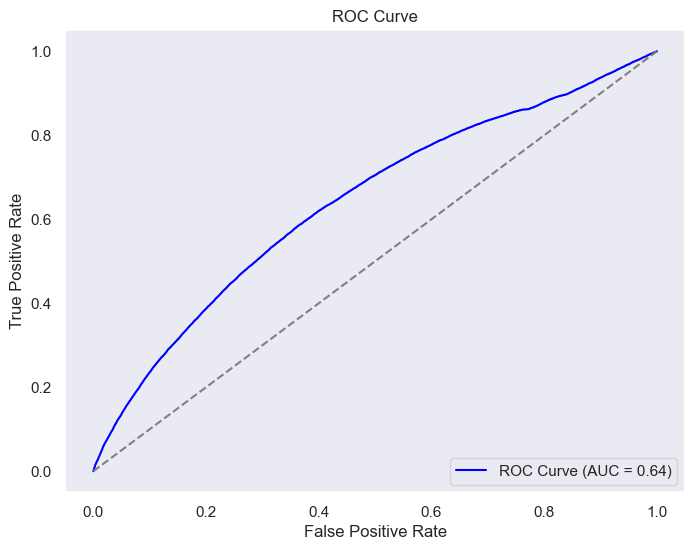

In [151]:
plot_roc_curve(model_lr, X_valid, Y_valid)

In [152]:
np.mean(cross_val_score(model_lr, X, Y, cv=5, scoring='recall'))

0.4668917692263008

In [153]:
submit = pd.read_csv('sample_submission.csv').drop(columns=['Unnamed: 0'])
submit['target'] = model_lr.predict_proba(test)[:, 1]
submit

,target
0,0.494937
1,0.557979
2,0.562876
3,0.448575
4,0.594353
...,...
301484,0.479236
301485,0.441819
301486,0.455554
301487,0.374702


In [154]:
submit.to_csv('res_baase.csv')

# Анализ моделей

In [155]:
model_lr = LogisticRegression(random_state=seed, class_weight='balanced')
model_lr.fit(X_train, Y_train)
print('LogisticRegression')

sgd = SGDClassifier(random_state=seed, loss='log_loss', class_weight='balanced')
sgd.fit(X_train, Y_train)
print('SGDClassifier')

cat = CatBoostClassifier(use_best_model=True, random_state=seed, verbose=500, auto_class_weights='Balanced')
cat.fit(X_train, Y_train, eval_set=(X_valid, Y_valid))
print('CatBoostClassifier')

xgb = XGBClassifier(random_state=seed, class_weight='balanced')
xgb.fit(X_train, Y_train, eval_set=[(X_valid, Y_valid)], verbose=10)
print('XGBClassifier')

lgbm = LGBMClassifier(random_state=seed, verbose=-1, class_weight='balanced')
lgbm.fit(X_train, Y_train, eval_set=[(X_valid, Y_valid)])
print('LGBMClassifier')

LogisticRegression
SGDClassifier
Learning rate set to 0.172298
0:	learn: 0.6723476	test: 0.6720773	best: 0.6720773 (0)	total: 95.7ms	remaining: 1m 35s
500:	learn: 0.5315707	test: 0.5695766	best: 0.5690553 (365)	total: 38.1s	remaining: 38s
999:	learn: 0.4964907	test: 0.5743235	best: 0.5690553 (365)	total: 1m 16s	remaining: 0us

bestTest = 0.5690553231
bestIteration = 365

Shrink model to first 366 iterations.
CatBoostClassifier
[0]	validation_0-logloss:0.27927
[10]	validation_0-logloss:0.24149
[20]	validation_0-logloss:0.23831
[30]	validation_0-logloss:0.23701
[40]	validation_0-logloss:0.23640
[50]	validation_0-logloss:0.23601
[60]	validation_0-logloss:0.23578
[70]	validation_0-logloss:0.23561
[80]	validation_0-logloss:0.23552
[90]	validation_0-logloss:0.23556
[99]	validation_0-logloss:0.23561
XGBClassifier
LGBMClassifier


In [156]:
evaluate_models(
    models=[model_lr, cat, xgb, lgbm, sgd],
    model_names=['LogisticRegression', 'CatBoostClassifier', 'XGBClassifier',
                 'LGBMClassifier', 
                 'SGDClassifier'],
    X=X_valid,
    Y=Y_valid
)

,Model,Accuracy,F1 Score,Recall,Precision,ROC AUC,Gini
0,LogisticRegression,0.726005,0.203721,0.456158,0.131146,0.641019,0.282038
1,CatBoostClassifier,0.703165,0.264652,0.695182,0.163436,0.772494,0.544988
2,XGBClassifier,0.923558,0.068285,0.036456,0.537948,0.767993,0.535986
3,LGBMClassifier,0.688312,0.260122,0.713081,0.159075,0.769500,0.539000
4,SGDClassifier,0.323772,0.158485,0.828745,0.087621,0.555243,0.110487


# Возьмем лучшую модель

In [157]:
# cat = CatBoostClassifier(
#     iterations=2 ** 16,
#     verbose=512,
#     loss_function='Logloss',
#     use_best_model=True,
#     random_seed=seed,
#     od_type='Iter',
#     od_wait=512,
#     auto_class_weights='Balanced',
#     task_type='GPU'
# )

cat = CatBoostClassifier(
    iterations=8192,
    verbose=512,
    loss_function='Logloss',
    use_best_model=True,
    learning_rate=0.008,
    random_seed=seed,
    l2_leaf_reg=8,
    grow_policy='Depthwise',
    depth=6,
    od_type='Iter',
    od_wait=512,
    rsm=1,
    fold_permutation_block=550,
    leaf_estimation_method='Newton',
    leaf_estimation_iterations=16,
    task_type='GPU'
)

cat.fit(X_train, Y_train, eval_set=(X_valid, Y_valid))

0:	learn: 0.6835483	test: 0.6835487	best: 0.6835487 (0)	total: 41.2ms	remaining: 5m 37s
512:	learn: 0.2371958	test: 0.2393415	best: 0.2393415 (512)	total: 9.65s	remaining: 2m 24s
1024:	learn: 0.2322752	test: 0.2363929	best: 0.2363929 (1024)	total: 19.1s	remaining: 2m 13s
1536:	learn: 0.2292609	test: 0.2351573	best: 0.2351573 (1536)	total: 28.7s	remaining: 2m 4s
2048:	learn: 0.2268758	test: 0.2344551	best: 0.2344551 (2048)	total: 38s	remaining: 1m 53s
2560:	learn: 0.2248375	test: 0.2339944	best: 0.2339944 (2560)	total: 46.9s	remaining: 1m 43s
3072:	learn: 0.2229788	test: 0.2336804	best: 0.2336804 (3072)	total: 55.8s	remaining: 1m 33s
3584:	learn: 0.2212630	test: 0.2334465	best: 0.2334465 (3584)	total: 1m 4s	remaining: 1m 23s
4096:	learn: 0.2196288	test: 0.2332725	best: 0.2332725 (4096)	total: 1m 13s	remaining: 1m 13s
4608:	learn: 0.2180632	test: 0.2331266	best: 0.2331266 (4608)	total: 1m 22s	remaining: 1m 4s
5120:	learn: 0.2165569	test: 0.2330125	best: 0.2330125 (5120)	total: 1m 31s	rem

In [158]:
evaluate_models(
    models=[cat],
    model_names=['CatBoostClassifier'],
    X=X_valid,
    Y=Y_valid
)

,Model,Accuracy,F1 Score,Recall,Precision,ROC AUC,Gini
0,CatBoostClassifier,0.924112,0.074779,0.039913,0.591463,0.777356,0.554711


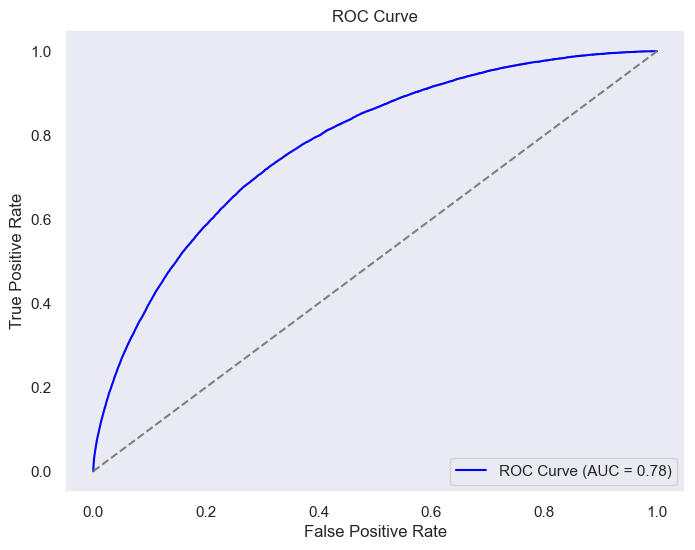

In [159]:
plot_roc_curve(cat, X_valid, Y_valid)

In [160]:
submit = pd.read_csv('sample_submission.csv').drop(columns=['Unnamed: 0'])
submit['target'] = cat.predict_proba(test)[:, 1]
submit

,target
0,0.048546
1,0.097956
2,0.067147
3,0.063191
4,0.120068
...,...
301484,0.030288
301485,0.017067
301486,0.067509
301487,0.014281


In [40]:
submit.to_csv('best_model.csv')

45.58009917626327

# Расмотрим еще одну относительно лучшую модель

In [41]:
lgbm = LGBMClassifier(
    n_estimators=1024,
    n_jobs=-1,
    random_state=seed,
    verbose=64,
    class_weight='balanced'
)

lgbm.fit(X_train, Y_train, eval_set=[(X_valid, Y_valid)])

[LightGBM] [Info] Number of positive: 72908, number of negative: 875972
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.868111
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.257204
[LightGBM] [Debug] init for col-wise cost 0.041076 seconds, init for row-wise cost 0.230356 seconds
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.259364 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19243
[LightGBM] [Info] Number of data points in the train set: 948880, number of used features: 97
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31

LGBMClassifier(class_weight='balanced', n_estimators=1024, n_jobs=-1,
               random_state=42, verbose=64)

In [42]:
evaluate_models(
    models=[lgbm],
    model_names=['LGBMClassifier'],
    X=X_valid,
    Y=Y_valid
)

,Model,Accuracy,F1 Score,Recall,Precision,ROC AUC,Gini
0,LGBMClassifier,0.734582,0.274279,0.652759,0.173614,0.769504,0.539009


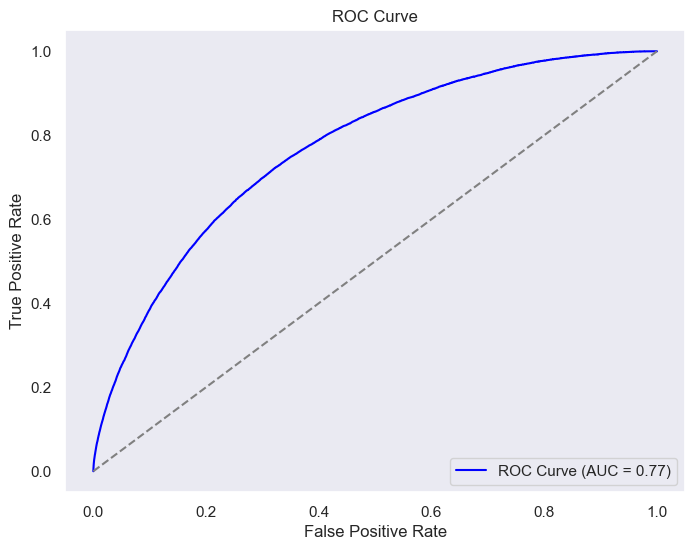

In [43]:
plot_roc_curve(lgbm, X_valid, Y_valid)

In [44]:
submit = pd.read_csv('sample_submission.csv').drop(columns=['Unnamed: 0'])
submit['target'] = lgbm.predict_proba(test)[:, 1]
submit

,target
0,0.258243
1,0.608165
2,0.486150
3,0.406933
4,0.420090
...,...
301484,0.218859
301485,0.094405
301486,0.387465
301487,0.099688


In [45]:
submit.to_csv('best_model2.csv')

## Попробуем заблендить результаты либо сделать ансамбль

In [273]:
met = evaluate_models(
    models=[lgbm, cat],
    model_names=['lgbm', 'cat'],
    X=X_valid,
    Y=Y_valid
)

In [274]:
cat_coef = float(met[['Model', 'Recall']].set_index('Model').loc['cat']) / met['Recall'].sum()
lgbm_coef = float(met[['Model', 'Recall']].set_index('Model').loc['lgbm']) / met['Recall'].sum()
cat_coef, lgbm_coef

(0.5169452818123687, 0.4830547181876314)

In [275]:
submit = pd.read_csv('sample_submission.csv').drop(columns=['Unnamed: 0'])
submit['target'] = (lgbm.predict_proba(test)[:, 1] + cat.predict_proba(test)[:, 1]) / 2
submit.to_csv('ensembl.csv')
submit

,target
0,0.308768
1,0.585216
2,0.452696
3,0.398558
4,0.509789
...,...
301484,0.209262
301485,0.119855
301486,0.396291
301487,0.104621


In [276]:
submit = pd.read_csv('sample_submission.csv').drop(columns=['Unnamed: 0'])
submit['target'] = lgbm.predict_proba(test)[:, 1] * lgbm_coef + cat.predict_proba(test)[:, 1] * cat_coef
submit.to_csv('blending.csv')
submit

,target
0,0.310480
1,0.584438
2,0.451562
3,0.398274
4,0.512829
...,...
301484,0.208936
301485,0.120717
301486,0.396590
301487,0.104788


## Стекинг

In [85]:
from sklearn.ensemble import StackingClassifier

In [86]:
estimators = [
    ('cat', CatBoostClassifier(random_state=seed, verbose=500, auto_class_weights='Balanced')),
    ('xgb', XGBClassifier(random_state=seed, class_weight='balanced')),
    ('lgbm', LGBMClassifier(random_state=seed, verbose=-1, class_weight='balanced'))
]

In [89]:
SC = StackingClassifier(
    estimators=estimators, 
    final_estimator=CatBoostClassifier(
        iterations=2 ** 13,
        verbose=512,
        loss_function='Logloss',
        random_seed=seed,
        od_type='Iter',
        od_wait=512,
        auto_class_weights='Balanced',
        task_type='GPU'
    ),
    n_jobs=-1
)
SC.fit(X_train, Y_train)

Learning rate set to 0.003513
0:	learn: 0.6922493	total: 26.1ms	remaining: 3m 33s
512:	learn: 0.5721271	total: 4.75s	remaining: 1m 11s
1024:	learn: 0.5679444	total: 9.4s	remaining: 1m 5s
1536:	learn: 0.5674009	total: 14s	remaining: 1m
2048:	learn: 0.5670897	total: 18.6s	remaining: 55.7s
2560:	learn: 0.5668040	total: 23.1s	remaining: 50.9s
3072:	learn: 0.5665286	total: 27.8s	remaining: 46.3s
3584:	learn: 0.5662537	total: 32.4s	remaining: 41.6s
4096:	learn: 0.5659831	total: 37.1s	remaining: 37.1s
4608:	learn: 0.5657130	total: 41.8s	remaining: 32.5s
5120:	learn: 0.5654546	total: 46.5s	remaining: 27.9s
5632:	learn: 0.5651965	total: 51.1s	remaining: 23.2s
6144:	learn: 0.5649502	total: 55.9s	remaining: 18.6s
6656:	learn: 0.5647093	total: 1m	remaining: 14s
7168:	learn: 0.5644693	total: 1m 5s	remaining: 9.35s
7680:	learn: 0.5642324	total: 1m 10s	remaining: 4.68s
8191:	learn: 0.5640010	total: 1m 15s	remaining: 0us


StackingClassifier(estimators=[('cat',
                                <catboost.core.CatBoostClassifier object at 0x000001991D954C90>),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              class_weight='balanced',
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types...
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None, ...)),
                               ('lgbm',
                                LGBMClassifier(class_weight='balanced',
                                               random_state=42, verbose=-1))],
                   final_estimator=<catboost.core.CatBoostClassifier object at 0x000001991D5ADAD0>,
                   n_jobs=-1)

In [90]:
SC.score(X_valid, Y_valid)

0.6816759091225253

In [91]:
evaluate_models(
    models=[SC],
    model_names=['StackingClassifier'],
    X=X_valid,
    Y=Y_valid
)

,Model,Accuracy,F1 Score,Recall,Precision,ROC AUC,Gini
0,StackingClassifier,0.681676,0.260709,0.730486,0.158669,0.77522,0.55044


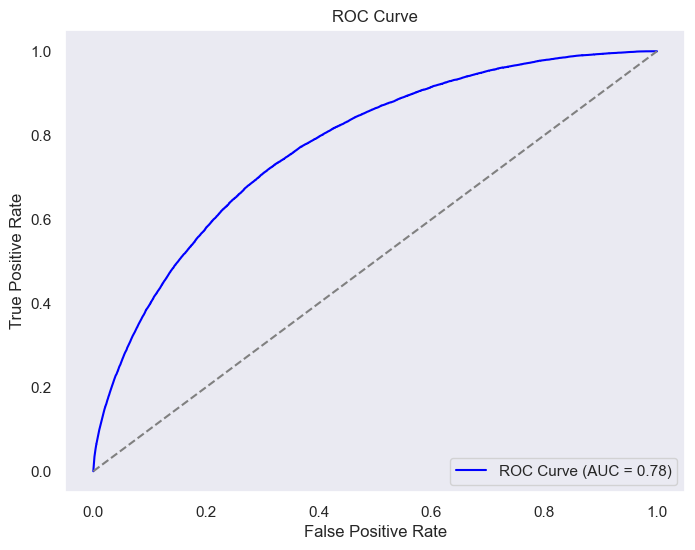

In [92]:
plot_roc_curve(SC, X_valid, Y_valid)

In [93]:
submit = pd.read_csv('sample_submission.csv').drop(columns=['Unnamed: 0'])
submit['target'] = SC.predict_proba(test)[:, 1]
submit.to_csv('StackingClassifier.csv')
submit

,target
0,0.369965
1,0.645969
2,0.466794
3,0.437074
4,0.528432
...,...
301484,0.282508
301485,0.177714
301486,0.460353
301487,0.098181


# другие методы по улучшению качества

## Resempl

In [48]:
from imblearn.over_sampling import ADASYN

In [49]:
X = data.drop(columns=['target'])
Y = data['target']
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, shuffle=True, random_state=seed, stratify=Y, test_size=0.25)

In [41]:
adasyn = ADASYN()

# Применение ADASYN к данным
X_train_resampled, Y_train_resampled = adasyn.fit_resample(X_train, Y_train)

In [56]:
cat = CatBoostClassifier(
    iterations=2 ** 16,
    verbose=512,
    loss_function='Logloss',
    use_best_model=True,
    random_seed=seed,
    od_type='Iter',
    od_wait=512,
    auto_class_weights='Balanced',
    task_type='GPU'
)

cat.fit(X_train_resampled, Y_train_resampled, eval_set=(X_valid, Y_valid))

Learning rate set to 0.006684
0:	learn: 0.6846342	test: 0.6898518	best: 0.6898518 (0)	total: 175ms	remaining: 3h 11m 19s
512:	learn: 0.1768799	test: 0.2704130	best: 0.2704130 (512)	total: 15.2s	remaining: 32m 7s
1024:	learn: 0.1579609	test: 0.2538963	best: 0.2538963 (1024)	total: 27.8s	remaining: 29m 10s
1536:	learn: 0.1496701	test: 0.2484386	best: 0.2484386 (1536)	total: 41.9s	remaining: 29m 3s
2048:	learn: 0.1449761	test: 0.2457724	best: 0.2457724 (2048)	total: 56s	remaining: 28m 56s
2560:	learn: 0.1418572	test: 0.2439687	best: 0.2439687 (2560)	total: 1m 8s	remaining: 28m 7s
3072:	learn: 0.1399487	test: 0.2427539	best: 0.2427539 (3072)	total: 1m 23s	remaining: 28m 14s


KeyboardInterrupt: 

In [51]:
evaluate_models(
    models=[cat],
    model_names=['CatBoostClassifier'],
    X=X_valid,
    Y=Y_valid
)

,Model,Accuracy,F1 Score,Recall,Precision,ROC AUC,Gini
0,CatBoostClassifier,0.924014,0.078027,0.041847,0.576204,0.77264,0.54528


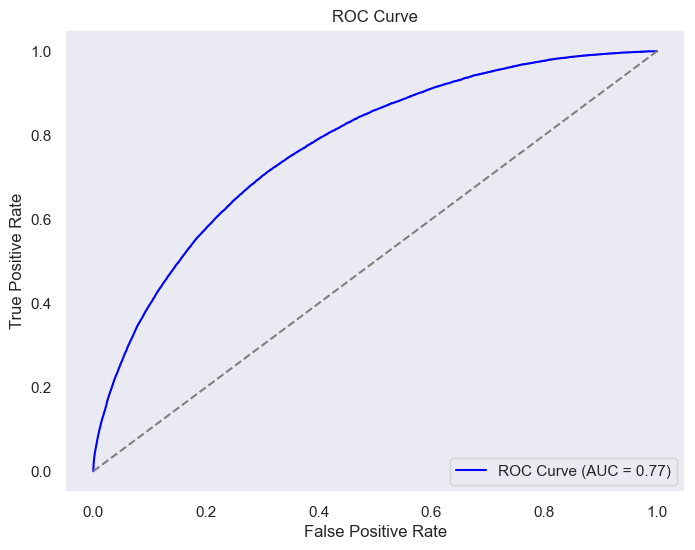

In [52]:
plot_roc_curve(cat, X_valid, Y_valid)

In [53]:
submit = pd.read_csv('sample_submission.csv').drop(columns=['Unnamed: 0'])
submit['target'] = cat.predict_proba(test)[:, 1]
submit.to_csv('ADASYN.csv')
submit

,target
0,0.069220
1,0.112194
2,0.076224
3,0.065789
4,0.115714
...,...
301484,0.035199
301485,0.021833
301486,0.053092
301487,0.010379


## RandomUnderSampler

In [220]:
from imblearn.under_sampling import RandomUnderSampler


X = data.drop(columns=['target'])
Y = data['target']

In [223]:
rus = RandomUnderSampler()
X_resampled, y_resampled = rus.fit_resample(X, Y)
len(X_resampled)

194422

In [226]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, shuffle=True, random_state=seed, test_size=0.25)

In [227]:
cat = CatBoostClassifier(
    iterations=2 ** 16,
    verbose=512,
    use_best_model=True,
    random_seed=seed,
    od_type='Iter',
    od_wait=512,
    auto_class_weights='Balanced',
    task_type='GPU'
)

cat.fit(X_train, Y_train, eval_set=(X_valid, Y_valid))

Learning rate set to 0.007038
0:	learn: 0.6921138	test: 0.6921268	best: 0.6921268 (0)	total: 19.1ms	remaining: 20m 52s
512:	learn: 0.5953538	test: 0.5971483	best: 0.5971483 (512)	total: 7.17s	remaining: 15m 8s
1024:	learn: 0.5832012	test: 0.5860392	best: 0.5860392 (1024)	total: 14.2s	remaining: 14m 54s
1536:	learn: 0.5768876	test: 0.5809537	best: 0.5809537 (1536)	total: 21.4s	remaining: 14m 50s
2048:	learn: 0.5723014	test: 0.5776856	best: 0.5776856 (2048)	total: 28.7s	remaining: 14m 48s
2560:	learn: 0.5685018	test: 0.5752866	best: 0.5752866 (2560)	total: 36s	remaining: 14m 44s
3072:	learn: 0.5653117	test: 0.5735460	best: 0.5735460 (3072)	total: 43.3s	remaining: 14m 40s
3584:	learn: 0.5624815	test: 0.5721868	best: 0.5721868 (3584)	total: 50.5s	remaining: 14m 32s
4096:	learn: 0.5599525	test: 0.5711834	best: 0.5711834 (4096)	total: 57.7s	remaining: 14m 25s
4608:	learn: 0.5575758	test: 0.5703209	best: 0.5703209 (4608)	total: 1m 4s	remaining: 14m 17s
5120:	learn: 0.5553399	test: 0.5696256	b

In [230]:
evaluate_models(
    models=[cat],
    model_names=['CatBoostClassifier'],
    X=X_valid,
    Y=Y_valid
)

,Model,Accuracy,F1 Score,Recall,Precision,ROC AUC,Gini
0,CatBoostClassifier,0.717067,0.269207,0.683999,0.167582,0.776308,0.552615


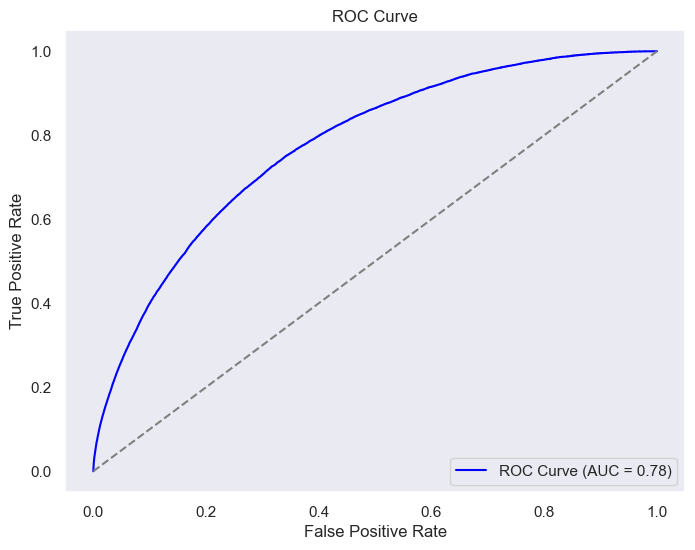

In [231]:
plot_roc_curve(cat, X_valid, Y_valid)

In [232]:
submit = pd.read_csv('sample_submission.csv').drop(columns=['Unnamed: 0'])
submit['target'] = cat.predict_proba(test)[:, 1]
submit.to_csv('best_model_RandomUnderSampler.csv')
submit

,target
0,0.360004
1,0.566924
2,0.465374
3,0.409455
4,0.601470
...,...
301484,0.192199
301485,0.200921
301486,0.450844
301487,0.112748


# Standart Scale

In [98]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler


scaler = MinMaxScaler()
scaler.fit(data.drop(columns=['target']))

MinMaxScaler()

In [99]:
X = scaler.transform(data.drop(columns=['target']))
Y = data['target']
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, shuffle=True, random_state=seed, stratify=Y, test_size=0.25)

In [152]:
cat = CatBoostClassifier(
    iterations=2 ** 16,
    verbose=512,
    use_best_model=True,
    random_seed=seed,
    od_type='Iter',
    od_wait=512,
    auto_class_weights='Balanced',
    task_type='GPU'
)

cat.fit(X_train, Y_train, eval_set=(X_valid, Y_valid))

0:	learn: 0.6919407	test: 0.6919439	best: 0.6919439 (0)	total: 13.6ms	remaining: 14m 50s
512:	learn: 0.5972799	test: 0.5969492	best: 0.5969492 (512)	total: 5.75s	remaining: 12m 9s
1024:	learn: 0.5862794	test: 0.5864858	best: 0.5864858 (1024)	total: 11.3s	remaining: 11m 51s
1536:	learn: 0.5807800	test: 0.5815898	best: 0.5815898 (1536)	total: 16.9s	remaining: 11m 43s
2048:	learn: 0.5769938	test: 0.5785223	best: 0.5785223 (2048)	total: 22.5s	remaining: 11m 36s
2560:	learn: 0.5740258	test: 0.5762930	best: 0.5762930 (2560)	total: 28s	remaining: 11m 28s
3072:	learn: 0.5715670	test: 0.5745953	best: 0.5745953 (3072)	total: 33.6s	remaining: 11m 22s
3584:	learn: 0.5694304	test: 0.5732031	best: 0.5732031 (3584)	total: 38.9s	remaining: 11m 12s
4096:	learn: 0.5675962	test: 0.5720958	best: 0.5720958 (4096)	total: 44.3s	remaining: 11m 4s
4608:	learn: 0.5658968	test: 0.5711532	best: 0.5711532 (4608)	total: 49.7s	remaining: 10m 56s
5120:	learn: 0.5643591	test: 0.5703612	best: 0.5703612 (5120)	total: 55

In [156]:
evaluate_models(
    models=[cat],
    model_names=['CatBoostClassifier'],
    X=X_valid,
    Y=Y_valid
)

,Model,Accuracy,F1 Score,Recall,Precision,ROC AUC,Gini
0,CatBoostClassifier,0.711357,0.271055,0.698432,0.168158,0.777702,0.555405


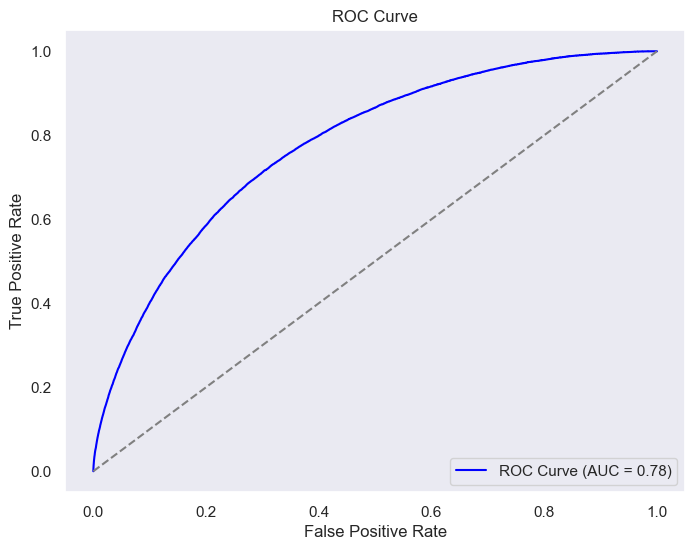

In [157]:
plot_roc_curve(cat, X_valid, Y_valid)

In [158]:
submit = pd.read_csv('sample_submission.csv').drop(columns=['Unnamed: 0'])
submit['target'] = cat.predict_proba(scaler.transform(test))[:, 1]
submit.to_csv('best_model_StandardScaler.csv')
submit

,target
0,0.366937
1,0.560798
2,0.411775
3,0.397220
4,0.606386
...,...
301484,0.208508
301485,0.146435
301486,0.405921
301487,0.108609


## Features selection

In [19]:
data

,graph_1,graph_2,graph_3,feature_1,bki_1,graph_4,feature_2,graph_5,feature_3,graph_6,...,graph_22,application_2,bki_14,bki_15,feature_37,bki_16,bki_17,mb_15,feature_38,target
0,73.0,25.0,63.0,0.0,-3.308594,59.0,36.0,19544.0,0.0,91.0,...,0.0,0,44211.0,31.0,390.414429,0.571289,0.000000,12527.0,0.0,0
1,64.0,37.0,68.0,0.0,-2.527344,106.0,36.0,1457.0,0.0,180.0,...,6.0,0,5600.0,3.0,663.702515,1.447266,0.099976,10276.0,0.0,0
2,73.0,34.0,80.0,0.0,-2.986328,72.0,44.0,13071.0,0.0,151.0,...,1.0,0,250889.0,8.0,360.067047,0.234985,11.242188,4588.0,0.0,0
3,170.0,99.0,203.0,0.0,-3.392578,228.0,34.0,7000.0,0.0,388.0,...,2.0,0,59695.0,3.0,471.623108,0.184692,9.968750,22968.0,0.0,0
4,65.0,20.0,77.0,0.0,-2.658203,115.0,18.0,21725.0,0.0,190.0,...,13.0,1,0.0,0.0,411.162415,0.000000,29.406250,15687.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1265169,2.0,2.0,1.0,0.0,-2.806641,5.0,34.0,0.0,0.0,7.0,...,1.0,0,59695.0,3.0,297.153595,0.184692,9.968750,2658.0,0.0,0
1265170,15.0,6.0,12.0,0.0,-2.970703,14.0,15.0,0.0,0.0,26.0,...,2.0,0,59695.0,3.0,56.500000,0.184692,9.968750,4694.0,0.0,0
1265171,240.0,135.0,356.0,0.0,-3.312500,401.0,35.0,689921.0,0.0,668.0,...,3.0,0,38000.0,4.0,552.291565,0.114075,25.562500,183997.0,205.0,0
1265172,17.0,2.0,6.0,0.0,-3.871094,22.0,34.0,500.0,0.0,40.0,...,4.0,0,59695.0,3.0,1475.000000,0.184692,9.968750,21792.0,0.0,0


In [20]:
data.columns

Index(['graph_1', 'graph_2', 'graph_3', 'feature_1', 'bki_1', 'graph_4',
       'feature_2', 'graph_5', 'feature_3', 'graph_6', 'graph_7', 'graph_8',
       'graph_9', 'graph_10', 'graph_11', 'graph_12', 'graph_13', 'bki_2',
       'graph_14', 'feature_5', 'mb_1', 'graph_15', 'mb_2', 'graph_16',
       'bki_3', 'feature_6', 'feature_7', 'mb_3', 'feature_8', 'feature_9',
       'graph_17', 'bki_4', 'feature_10', 'feature_11', 'feature_12',
       'feature_13', 'feature_14', 'mb_4', 'feature_15', 'mb_5', 'graph_18',
       'bki_5', 'feature_16', 'partner_1', 'feature_17', 'feature_18',
       'partner_2', 'bki_6', 'feature_19', 'feature_20', 'mb_6', 'feature_21',
       'bki_7', 'feature_22', 'mb_7', 'feature_23', 'mb_8', 'bki_8', 'mb_9',
       'mb_10', 'bki_9', 'feature_24', 'partner_4', 'feature_25', 'feature_26',
       'feature_27', 'partner_5', 'application_1', 'feature_28', 'mb_11',
       'mb_12', 'feature_29', 'bki_10', 'bki_11', 'feature_30', 'feature_31',
       'bki_12', 'fea

In [21]:
from itertools import combinations


def preproc(df: pd.DataFrame) -> pd.DataFrame:
    # Перебор групп признаков
    for i in ['graph', 'bki']:
        # Получаем все столбцы, которые содержат текущую группу признаков
        group_columns = [k for k in df.columns if i in k]
        
        # Генерация всех возможных комбинаций признаков в группе
        for col1, col2 in combinations(group_columns, 2):
            # Создание новых признаков на основе операций
            df[f'{col1}_plus_{col2}'] = df[col1] + df[col2]
            df[f'{col1}_minus_{col2}'] = df[col1] - df[col2]
    df = reduce_mem_usage(df)
    return df

In [22]:
data_selection = preproc(data)
data_selection

Memory usage of dataframe is 2814.91 MB
Memory usage after optimization is: 2814.91 MB
Decreased by 0.0%


,graph_1,graph_2,graph_3,feature_1,bki_1,graph_4,feature_2,graph_5,feature_3,graph_6,...,bki_14_plus_bki_16,bki_14_minus_bki_16,bki_14_plus_bki_17,bki_14_minus_bki_17,bki_15_plus_bki_16,bki_15_minus_bki_16,bki_15_plus_bki_17,bki_15_minus_bki_17,bki_16_plus_bki_17,bki_16_minus_bki_17
0,73.0,25.0,63.0,0.0,-3.308594,59.0,36.0,19544.0,0.0,91.0,...,44211.570312,44210.429688,44211.000000,44211.000000,31.578125,30.421875,31.000000,31.000000,0.571289,0.571289
1,64.0,37.0,68.0,0.0,-2.527344,106.0,36.0,1457.0,0.0,180.0,...,5601.447266,5598.552734,5600.100098,5599.899902,4.445312,1.552734,3.099609,2.900391,1.546875,1.347656
2,73.0,34.0,80.0,0.0,-2.986328,72.0,44.0,13071.0,0.0,151.0,...,250889.234375,250888.765625,250900.250000,250877.750000,8.234375,7.765625,19.250000,-3.242188,11.476562,-11.007812
3,170.0,99.0,203.0,0.0,-3.392578,228.0,34.0,7000.0,0.0,388.0,...,59695.183594,59694.816406,59704.968750,59685.031250,3.185547,2.814453,12.968750,-6.968750,10.156250,-9.781250
4,65.0,20.0,77.0,0.0,-2.658203,115.0,18.0,21725.0,0.0,190.0,...,0.000000,0.000000,29.406250,-29.406250,0.000000,0.000000,29.406250,-29.406250,29.406250,-29.406250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1265169,2.0,2.0,1.0,0.0,-2.806641,5.0,34.0,0.0,0.0,7.0,...,59695.183594,59694.816406,59704.968750,59685.031250,3.185547,2.814453,12.968750,-6.968750,10.156250,-9.781250
1265170,15.0,6.0,12.0,0.0,-2.970703,14.0,15.0,0.0,0.0,26.0,...,59695.183594,59694.816406,59704.968750,59685.031250,3.185547,2.814453,12.968750,-6.968750,10.156250,-9.781250
1265171,240.0,135.0,356.0,0.0,-3.312500,401.0,35.0,689921.0,0.0,668.0,...,38000.113281,37999.886719,38025.562500,37974.437500,4.113281,3.886719,29.562500,-21.562500,25.671875,-25.453125
1265172,17.0,2.0,6.0,0.0,-3.871094,22.0,34.0,500.0,0.0,40.0,...,59695.183594,59694.816406,59704.968750,59685.031250,3.185547,2.814453,12.968750,-6.968750,10.156250,-9.781250


In [23]:
X = data_selection.drop(columns=['target'])
Y = data_selection['target']

In [27]:
catboost_model = CatBoostClassifier(random_state=seed, verbose=500, auto_class_weights='Balanced')
catboost_model.fit(X, Y)

lightgbm_model = LGBMClassifier(random_state=seed, verbose=-1, class_weight='balanced')
lightgbm_model.fit(X, Y)

xgboost_model = XGBClassifier(random_state=seed, class_weight='balanced')
xgboost_model.fit(X, Y)

# Получение важности признаков
catboost_importance = catboost_model.get_feature_importance()
lightgbm_importance = lightgbm_model.feature_importances_
xgboost_importance = xgboost_model.feature_importances_

Learning rate set to 0.217547
0:	learn: 0.6652453	total: 488ms	remaining: 8m 7s
500:	learn: 0.5258804	total: 3m 45s	remaining: 3m 44s
999:	learn: 0.4891260	total: 7m 19s	remaining: 0us


In [28]:
# Создание DataFrame для каждой модели
catboost_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': catboost_importance
}).sort_values('Importance', ascending=False)

lightgbm_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': lightgbm_importance
}).sort_values('Importance', ascending=False)

xgboost_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgboost_importance
}).sort_values('Importance', ascending=False)

In [29]:
catboost_df

,Feature,Importance
6,feature_2,2.229998
3,feature_1,1.833394
196,graph_3_minus_graph_12,1.729356
151,graph_2_plus_graph_9,1.658603
536,graph_17_minus_graph_21,1.149212
...,...,...
687,bki_5_plus_bki_12,0.000000
688,bki_5_minus_bki_12,0.000000
690,bki_5_minus_bki_13,0.000000
389,graph_9_plus_graph_16,0.000000


In [30]:
lightgbm_df

,Feature,Importance
6,feature_2,147
3,feature_1,61
22,mb_2,53
38,feature_15,51
25,feature_6,50
...,...,...
544,graph_18_minus_graph_21,0
276,graph_5_minus_graph_17,0
278,graph_5_minus_graph_18,0
280,graph_5_minus_graph_19,0


In [31]:
xgboost_df

,Feature,Importance
151,graph_2_plus_graph_9,0.166750
536,graph_17_minus_graph_21,0.038250
164,graph_2_minus_graph_15,0.034710
196,graph_3_minus_graph_12,0.017340
3,feature_1,0.014841
...,...,...
483,graph_13_plus_graph_21,0.000000
738,bki_7_minus_bki_16,0.000000
423,graph_10_plus_graph_21,0.000000
24,bki_3,0.000000


In [32]:
corr_matrix = data_selection.corr()

corr_matrix.corrwith(corr_matrix.target).abs().sort_values()

bki_10_minus_bki_16        0.000227
graph_11_minus_graph_16    0.000487
bki_2_minus_bki_16         0.001033
bki_1_minus_bki_16         0.002103
bki_3_minus_bki_9          0.002651
                             ...   
graph_3_plus_graph_12      0.897123
graph_1_plus_graph_4       0.897234
graph_2_plus_graph_12      0.897713
graph_1_plus_graph_3       0.897890
target                     1.000000
Length: 832, dtype: float64

In [33]:
tol = [(i, j) for i, j in corr_matrix.corrwith(corr_matrix.target).abs().sort_values().items() if j > 0.04]
print(len(tol))
total = []

cat_top, lgbm_top, xgb_top = catboost_df['Feature'].tolist()[:64], lightgbm_df['Feature'].tolist()[:64], xgboost_df['Feature'].tolist()[:64]
for i, j in tol:
    if i in cat_top and i in lgbm_top and i in xgb_top:
        total.append(i)
print(len(total))

729
25


In [34]:
total

['graph_5_plus_graph_16',
 'feature_15',
 'partner_1',
 'feature_7',
 'feature_28',
 'feature_11',
 'feature_1',
 'feature_26',
 'bki_1_plus_bki_4',
 'feature_14',
 'partner_2',
 'feature_12',
 'graph_10_minus_graph_13',
 'graph_8_plus_graph_10',
 'feature_22',
 'graph_6_minus_graph_21',
 'feature_5',
 'feature_19',
 'feature_6',
 'mb_2',
 'mb_1',
 'graph_17_minus_graph_21',
 'graph_2_plus_graph_9',
 'graph_2_minus_graph_12',
 'graph_3_minus_graph_12']

<Axes: >

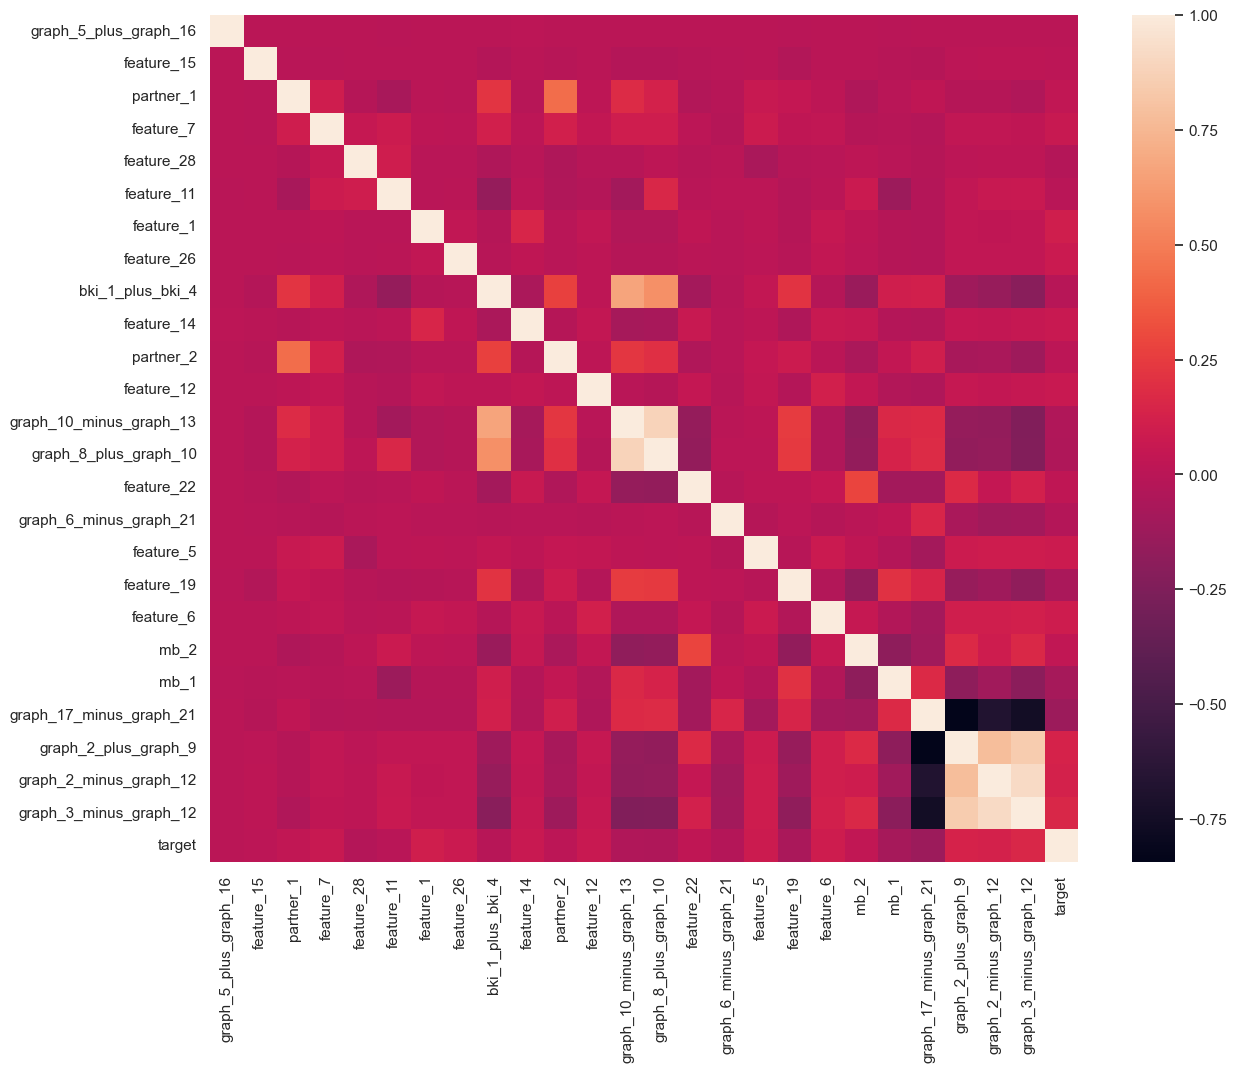

In [44]:
sns.set(rc={'figure.figsize': (14, 11)})

sns.heatmap(data_selection[total + ['target']].corr(), annot=False)

In [36]:
X = data_selection[total]
Y = data_selection['target']
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, shuffle=True, random_state=seed, stratify=Y, test_size=0.25)

In [37]:
cat = CatBoostClassifier(
    iterations=2 ** 16,
    verbose=512,
    loss_function='Logloss',
    use_best_model=True,
    random_seed=seed,
    od_type='Iter',
    od_wait=512,
    auto_class_weights='Balanced',
    task_type='GPU'
)

cat.fit(X_train, Y_train, eval_set=(X_valid, Y_valid))

Learning rate set to 0.007038
0:	learn: 0.6920944	test: 0.6920893	best: 0.6920893 (0)	total: 22.7ms	remaining: 24m 45s
512:	learn: 0.5976880	test: 0.5977104	best: 0.5977104 (512)	total: 5.21s	remaining: 10m 59s
1024:	learn: 0.5899897	test: 0.5909109	best: 0.5909109 (1024)	total: 10.4s	remaining: 10m 54s
1536:	learn: 0.5866278	test: 0.5887250	best: 0.5887250 (1536)	total: 15.6s	remaining: 10m 50s
2048:	learn: 0.5841719	test: 0.5875087	best: 0.5875087 (2048)	total: 20.9s	remaining: 10m 46s
2560:	learn: 0.5820525	test: 0.5866961	best: 0.5866960 (2559)	total: 26.1s	remaining: 10m 41s
3072:	learn: 0.5801921	test: 0.5861547	best: 0.5861547 (3072)	total: 31.5s	remaining: 10m 39s
3584:	learn: 0.5785278	test: 0.5857983	best: 0.5857977 (3582)	total: 36.8s	remaining: 10m 36s
4096:	learn: 0.5769602	test: 0.5855339	best: 0.5855327 (4095)	total: 42.2s	remaining: 10m 32s
4608:	learn: 0.5754921	test: 0.5853397	best: 0.5853396 (4607)	total: 47.5s	remaining: 10m 28s
5120:	learn: 0.5740641	test: 0.585175

In [38]:
evaluate_models(
    models=[cat],
    model_names=['CatBoostClassifier'],
    X=X_valid,
    Y=Y_valid
)

,Model,Accuracy,F1 Score,Recall,Precision,ROC AUC,Gini
0,CatBoostClassifier,0.686096,0.252286,0.689215,0.154402,0.755222,0.510444


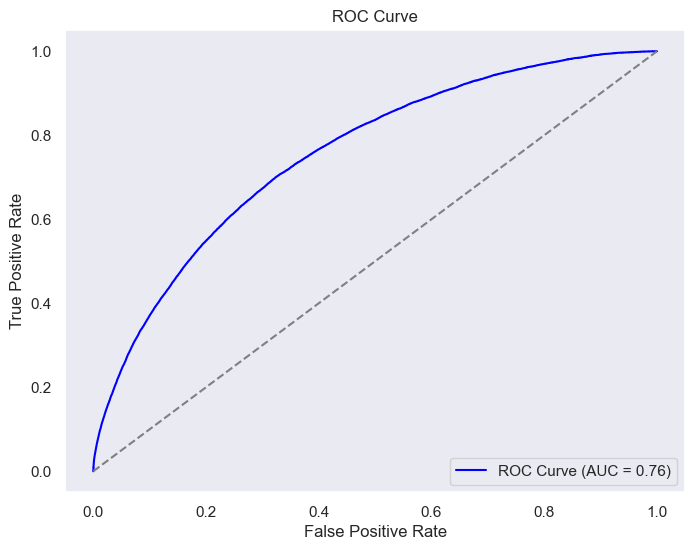

In [39]:
plot_roc_curve(cat, X_valid, Y_valid)

In [42]:
test_selection = preproc(test)[total]

Memory usage of dataframe is 656.99 MB
Memory usage after optimization is: 657.56 MB
Decreased by -0.1%


In [43]:
submit = pd.read_csv('sample_submission.csv').drop(columns=['Unnamed: 0'])
submit['target'] = cat.predict_proba(test_selection)[:, 1]
submit.to_csv('best_model_features_selection.csv')
submit

,target
0,0.409910
1,0.613334
2,0.329988
3,0.777843
4,0.334770
...,...
301484,0.363095
301485,0.104762
301486,0.491807
301487,0.177811


# PCA

In [116]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA


scaler = MinMaxScaler()
scaler.fit(data.drop(columns=['target']))

MinMaxScaler()

In [117]:
X = scaler.transform(data.drop(columns=['target']))
Y = data['target']

In [118]:
cov_matrix = np.cov(X, rowvar=False)
cov_matrix

array([[ 9.60844653e-05,  8.05990094e-05,  9.02959049e-05, ...,
        -1.88687860e-06,  1.71534036e-05,  3.33981674e-05],
       [ 8.05990094e-05,  1.03220179e-04,  1.11833060e-04, ...,
        -1.60222634e-06,  2.92539262e-05,  3.99530800e-05],
       [ 9.02959049e-05,  1.11833060e-04,  1.24757388e-04, ...,
        -1.55879127e-06,  3.47974614e-05,  4.44750529e-05],
       ...,
       [-1.88687860e-06, -1.60222634e-06, -1.55879127e-06, ...,
         2.53606209e-05,  1.94479720e-06, -6.08796826e-07],
       [ 1.71534036e-05,  2.92539262e-05,  3.47974614e-05, ...,
         1.94479720e-06,  3.65110677e-04,  1.18975289e-04],
       [ 3.33981674e-05,  3.99530800e-05,  4.44750529e-05, ...,
        -6.08796826e-07,  1.18975289e-04,  5.18844652e-04]])

In [120]:
pca = PCA(0.95)  # сохраняем 95% доли объясненной дисперсии
X_reduced = pca.fit_transform(X)
X_reduced.shape

(1265174, 32)

In [121]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X_reduced, Y, shuffle=True, random_state=seed, stratify=Y, test_size=0.25)

In [122]:
cat = CatBoostClassifier(
    iterations=2 ** 16,
    verbose=512,
    loss_function='Logloss',
    use_best_model=True,
    random_seed=seed,
    od_type='Iter',
    od_wait=512,
    auto_class_weights='Balanced',
    task_type='GPU'
)

cat.fit(X_train, Y_train, eval_set=(X_valid, Y_valid))

Learning rate set to 0.007038
0:	learn: 0.6925554	test: 0.6925383	best: 0.6925383 (0)	total: 15.5ms	remaining: 16m 58s
512:	learn: 0.6317934	test: 0.6318822	best: 0.6318822 (512)	total: 6.17s	remaining: 13m 1s
1024:	learn: 0.6226700	test: 0.6240060	best: 0.6240060 (1024)	total: 12.3s	remaining: 12m 55s
1536:	learn: 0.6175881	test: 0.6202752	best: 0.6202752 (1536)	total: 18.5s	remaining: 12m 48s
2048:	learn: 0.6137091	test: 0.6178471	best: 0.6178471 (2048)	total: 24.6s	remaining: 12m 40s
2560:	learn: 0.6104754	test: 0.6160805	best: 0.6160805 (2560)	total: 30.6s	remaining: 12m 32s
3072:	learn: 0.6076479	test: 0.6147614	best: 0.6147614 (3072)	total: 36.7s	remaining: 12m 25s
3584:	learn: 0.6051343	test: 0.6137619	best: 0.6137619 (3584)	total: 42.7s	remaining: 12m 18s
4096:	learn: 0.6028332	test: 0.6129558	best: 0.6129558 (4096)	total: 48.7s	remaining: 12m 11s
4608:	learn: 0.6006575	test: 0.6122648	best: 0.6122648 (4608)	total: 54.8s	remaining: 12m 4s
5120:	learn: 0.5986094	test: 0.6116636	

In [123]:
evaluate_models(
    models=[cat],
    model_names=['CatBoostClassifier'],
    X=X_valid,
    Y=Y_valid
)

,Model,Accuracy,F1 Score,Recall,Precision,ROC AUC,Gini
0,CatBoostClassifier,0.684784,0.238302,0.641731,0.146318,0.728376,0.456752


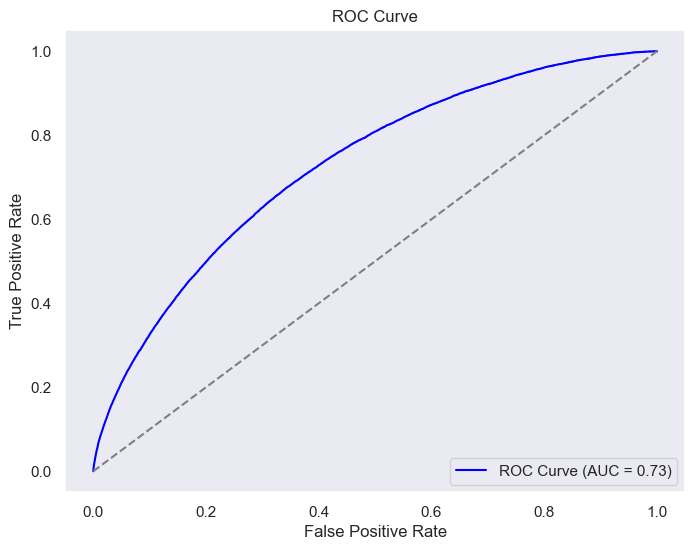

In [124]:
plot_roc_curve(cat, X_valid, Y_valid)

In [126]:
submit = pd.read_csv('sample_submission.csv').drop(columns=['Unnamed: 0'])
submit['target'] = cat.predict_proba(pca.transform(scaler.transform(test)))[:, 1]
submit.to_csv('PCA.csv')
submit

,target
0,0.408728
1,0.406477
2,0.476139
3,0.567612
4,0.595215
...,...
301484,0.563769
301485,0.303214
301486,0.645563
301487,0.315163
